In [1]:
import arviz as az
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D
style.use('plotting.mplstyle')
import numpy as np
np.random.seed(150914)
import json
from scipy.special import erf

In [2]:
# Read in inference data
data_doubleGaussian = az.from_netcdf("../data/effective_spin_doubleGaussians.cdf")
stacked_samples_doubleGaussian = data_doubleGaussian.posterior.stack(draws=("chain", "draw"))

data_singleGaussian = az.from_netcdf("../data/effective_spin_gaussian.cdf")
stacked_samples_singleGaussian = data_singleGaussian.posterior.stack(draws=("chain", "draw"))

In [3]:
# Define a truncated Gaussian distribution
def gaussian(samples,mu,sigma,lowCutoff,highCutoff):
    a = (lowCutoff-mu)/np.sqrt(2*sigma**2)
    b = (highCutoff-mu)/np.sqrt(2*sigma**2)
    norm = np.sqrt(sigma**2*np.pi/2)*(-erf(a) + erf(b))
    return np.exp(-(samples-mu)**2/(2.*sigma**2))/norm

In [4]:
# We'll evaluate our double Gaussian posterior across a grid of chi values
grid = np.linspace(-1,1,2000)
nSamps = 1000
pdf_doubleGaussian = np.zeros((nSamps,grid.size))

# Loop across a random set of posterior samples
samples_to_plot = np.random.choice(np.arange(stacked_samples_doubleGaussian.mu_chi_high.size),nSamps,replace=False)
for i,sample in enumerate(samples_to_plot):
    
    # Read out hyperparameters
    mu_chi_high = stacked_samples_doubleGaussian.mu_chi_high.values[sample]
    mu_chi_low = stacked_samples_doubleGaussian.mu_chi_low.values[sample]
    logsig_chi_high = stacked_samples_doubleGaussian.logsig_chi_high.values[sample]
    logsig_chi_low = stacked_samples_doubleGaussian.logsig_chi_low.values[sample]
    zeta_high = stacked_samples_doubleGaussian.zeta_high.values[sample]
    
    # Compute and store PDF
    pdf_doubleGaussian[i,:] = (1.-zeta_high)*gaussian(grid,mu_chi_low,10.**logsig_chi_low,-1,1) + zeta_high*gaussian(grid,mu_chi_high,10.**logsig_chi_high,-1,1)

In [5]:
# Similarly evaluate our single Gaussian model posterior across a grid of chi values
nSamps = 1000
pdf_singleGaussian = np.zeros((nSamps,grid.size))

# Loop across a random set of posterior samples
samples_to_plot = np.random.choice(np.arange(stacked_samples_singleGaussian.mu_chi.size),nSamps,replace=False)
for i,sample in enumerate(samples_to_plot):
    
    # Read out hyperparameters
    mu_chi = stacked_samples_singleGaussian.mu_chi.values[sample]
    logsig_chi = stacked_samples_singleGaussian.logsig_chi.values[sample]
    
    # Compute and store PDF
    pdf_singleGaussian[i,:] = gaussian(grid,mu_chi,10.**logsig_chi,-1,1)

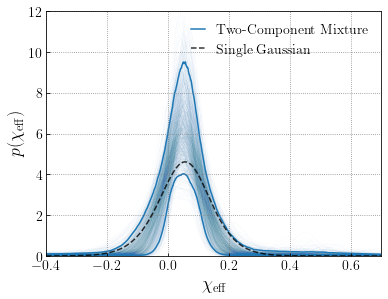

In [6]:
fig,ax = plt.subplots(figsize=(6,4.5))

ax.plot(grid,pdf_doubleGaussian.T,color='#1f78b4',lw=0.1,alpha=0.1,zorder=0)
ax.plot(grid,np.quantile(pdf_doubleGaussian,0.05,axis=0),color='#1f78b4',zorder=1,label='Two-Component Mixture')
ax.plot(grid,np.quantile(pdf_doubleGaussian,0.95,axis=0),color='#1f78b4',zorder=1)

ax.set_xlim(-0.4,0.7)
ax.set_ylim(0,12)

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'$p(\chi_\mathrm{eff})$',fontsize=18)
ax.tick_params(axis='both', labelsize=14)
ax.axes.grid(True,which='major',ls=':',color='grey')

ax.plot(grid,np.mean(pdf_singleGaussian,axis=0),color='black',ls='--',alpha=0.8,label='Single Gaussian')
ax.legend(loc='upper right',frameon=False,fontsize=14,handlelength=1)

ax.set_rasterization_zorder(1)
plt.savefig('./figure_04.pdf',bbox_inches='tight',dpi=200)

plt.show()